El objetivo de las actividades propuestas es desarrollar intuición sobre la estructura semántica subyacente en embeddings de documentos y palabras básicos generados a partir de conteos y hacer un análisis exploratorio de forma cualitativa. Para ello se trabajará con el dataset 20 Newsgroups (disponible a través de sklearn) y diferentes formas de construir embeddings de documentos y de palabras:



1.  Usar las vectorizaciones disponibles en sklearn de CountVectorizer y TfidfVectorizer para construir la matriz de documento-término. Esto proveerá de embeddings para cada documento. Con esta vectorización explorar similaridad entre documentos (tomar algún documento y evaluar los documentos correspondientes con mayor similaridad), dado que el dataset provee también clasificación anotada en tópicos se aprovechar esta clasificación como elemento extra para comprobar la similaridad de documentos. Explorar vectorizar con diferentes cantidades de n-gramas. Toda exploración adicional a las mencionadas es bienvenida.
2. Repetir la exploración de similaridad de documentos pero utilizando la vectorización resultante de aplicar truncated SVD (disponible en sklearn) a la matriz de documento-término.
3. Transponer la matriz documento-término, esto resultará en la matriz término-documento que provee embeddings de palabras. Explorar similaridad entre términos.
4. Construir la matriz término-clase con las clases disponibles en 20 Newsgroups y con estos embeddings de palabras resultantes explorar similaridad entre términos.
5. Construir la matriz término-término utilizando una ventana de contexto. Para construir esta matriz serán útiles las funcionalidades de Keras make_sampling_table, skipgrams y el tokenizador de Keras. Explorar resultados de similaridad de términos con diferentes tamaños de contexto.
6. Con la matriz término-término construir la matriz de PPMI y factorizarla aplicando truncated SVD. Explorar resultados de similaridad término a término.


Para la entrega enviar un link a un repositorio que contenga las notebooks donde esté asentada la actividad y resultados y archivos de código asociados.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from keras.preprocessing.text import Tokenizer
from scipy.sparse import csr_matrix,lil_matrix
from matplotlib import pyplot as plt
import numpy as np
import random
%matplotlib ipympl

2023-08-26 23:47:05.388406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TNG_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))

In [13]:
TNG_train.target_names


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [14]:
cv = TfidfVectorizer(ngram_range=(1,1), max_df=1.0, min_df=1, max_features=None, stop_words='english')
res = cv.fit_transform(TNG_train.data)
display(res)

<11314x101322 sparse matrix of type '<class 'numpy.float64'>'
	with 755809 stored elements in Compressed Sparse Row format>

In [28]:
cv = CountVectorizer(ngram_range=(1,2), max_df=1.0, min_df=1, max_features=None, stop_words='english')
res = cv.fit_transform(TNG_train.data)
display(res)

<11314x943737 sparse matrix of type '<class 'numpy.int64'>'
	with 1814080 stored elements in Compressed Sparse Row format>

Parece que las stops words default de sklearn no estan tan buenas. https://scikit-learn.org/stable/modules/feature_extraction.html#stop-words

In [7]:
len(cv.get_feature_names_out())

943737

In [8]:
matriz_similaridad = cosine_similarity(res)
print(matriz_similaridad.shape)

(11314, 11314)


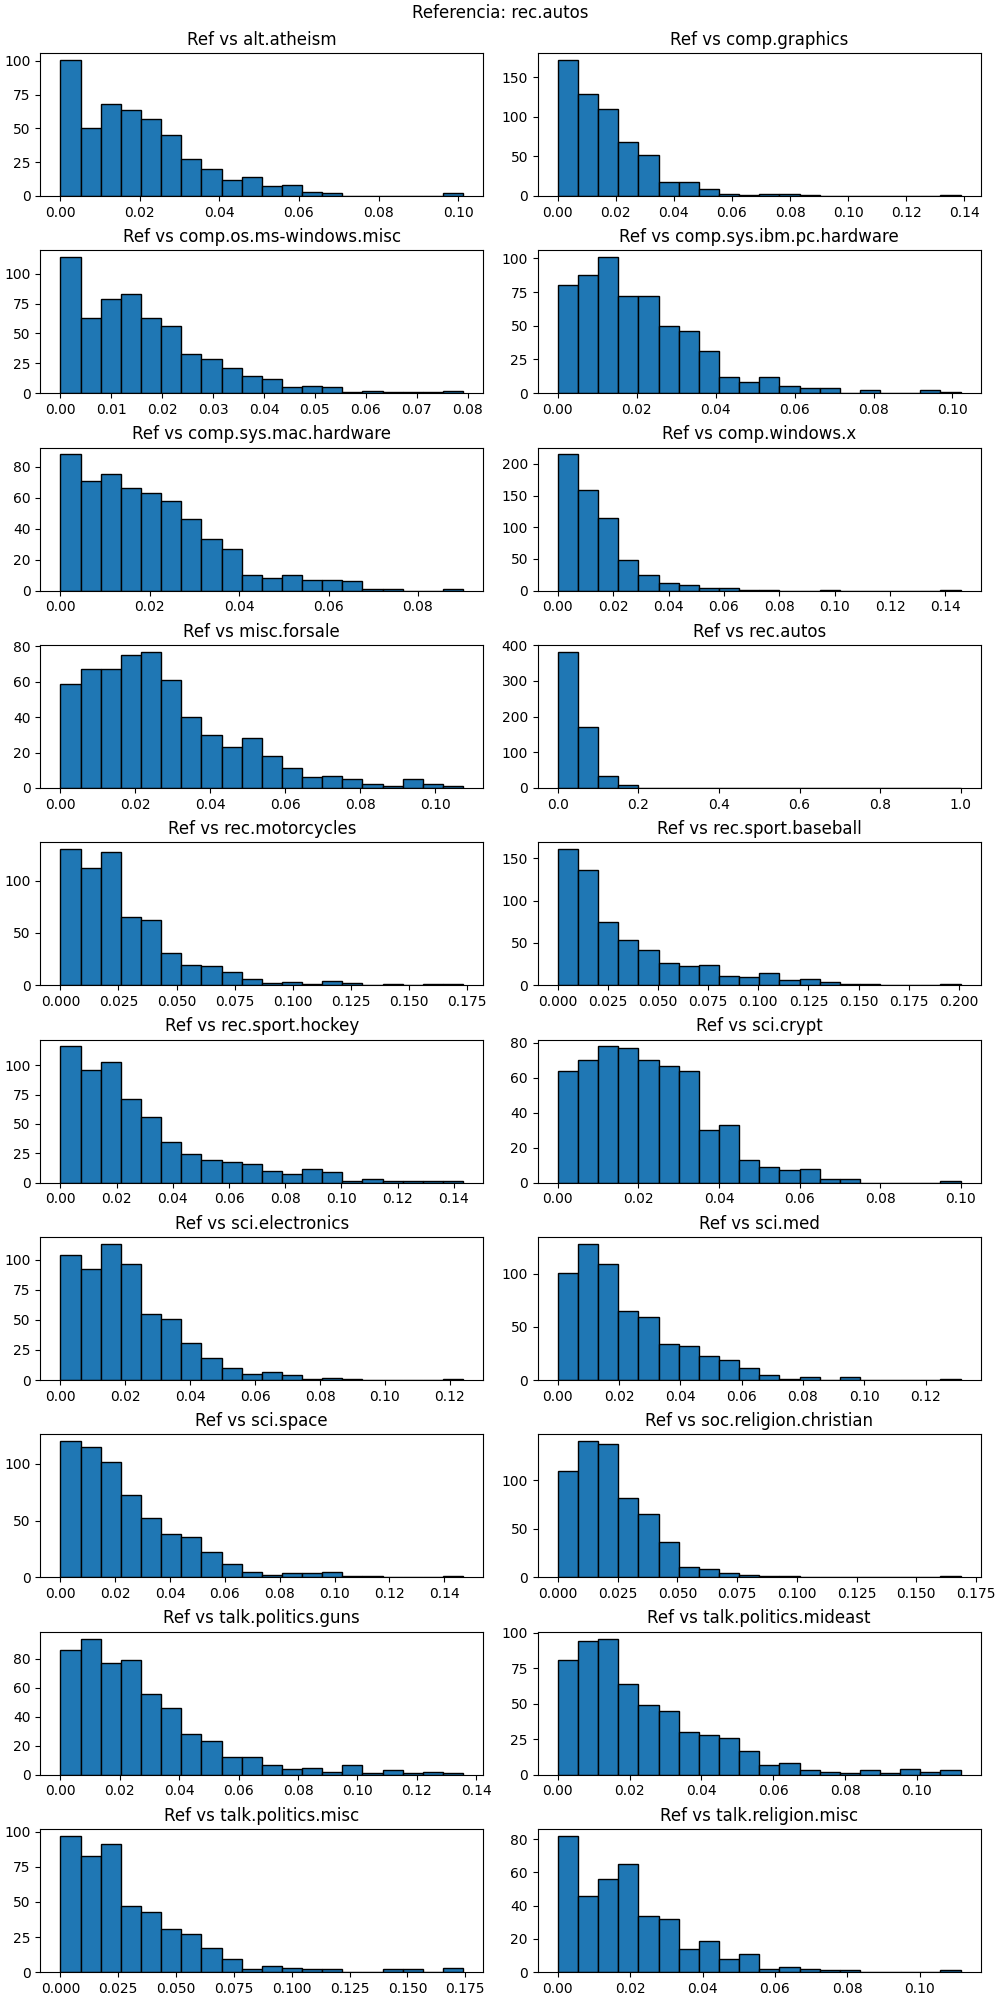

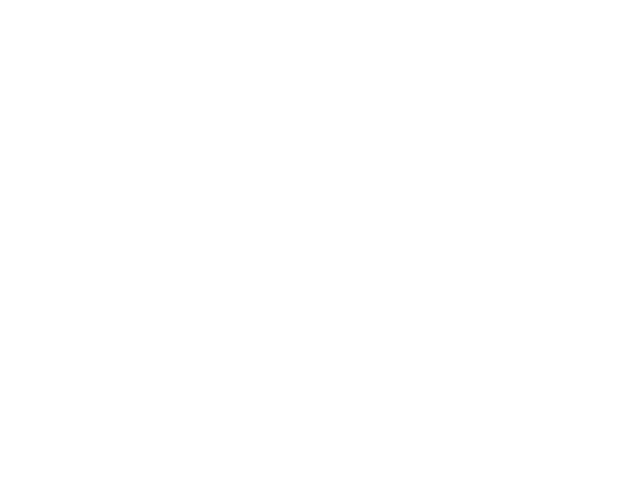

In [9]:
# Hago un diccionario para agrupar los articulos por categoria
articles_by_category = {}
indexes_by_category = {}

for i, category in enumerate(TNG_train.target_names):
    category_articles = np.array([[TNG_train.data[j], j] for j in range(len(TNG_train.data)) if TNG_train.target[j] == i])
    articles_by_category[category] = category_articles

reference_article = random.choice(TNG_train.target)

plt.clf()
fig = plt.figure(figsize=(10, 20), constrained_layout=True, )

fig.suptitle(f"Referencia: {TNG_train.target_names[TNG_train.target[reference_article]]}")
for i, category in enumerate(TNG_train.target_names):
    plt.subplot(10, 2, i+1)
    plt.title(f'Ref vs {category}')
    hist_data = [matriz_similaridad[reference_article, int(j)] for j in articles_by_category[category][..., 1] if j != reference_article]
    plt.hist(hist_data, edgecolor='black', bins=20)

plt.show()


Unigrams y TFIDF: A simple vista, los graficos no parecen tan piola, pero si se mira el eje Y, se puede ver que para la misma categoria, la similitud coseno tiende a distribuirse mas, mientras que en otras categorias eso no ocurre. Lo que es mas, para una misma categoria, el eje X muestra que se extiende a valores bastante altos, por mas que hayan pocas ocurrencias. 

UNI-BIGRAMS y TFIDF: Muy similar a la conclisuion de arriba, pero para categorias, que a mi criterio, son muchos mas distintas, los valroes de similitud se hicieron un poco mas bajos, pero no tanto.

UNI-BI-TRIGRAMS y TFIDF: mismas caracteristicas, pero en este ejemplo particular pude ver que la categoria talk.religion.misc es muy similar a la categoria soc.religion.christian, lo cual tiene bastante sentido ya que probablemente estas cosas sean de EEUU y la poblacion haya es ultra cristiana.

CountVec: Me resulto bastante similar al TFIDF





# TruncatedSVD


In [ ]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = red.fit_transform(res)

In [14]:
matriz_similaridad = cosine_similarity(TNG_cv_red)
print(matriz_similaridad.shape)

(11314, 11314)


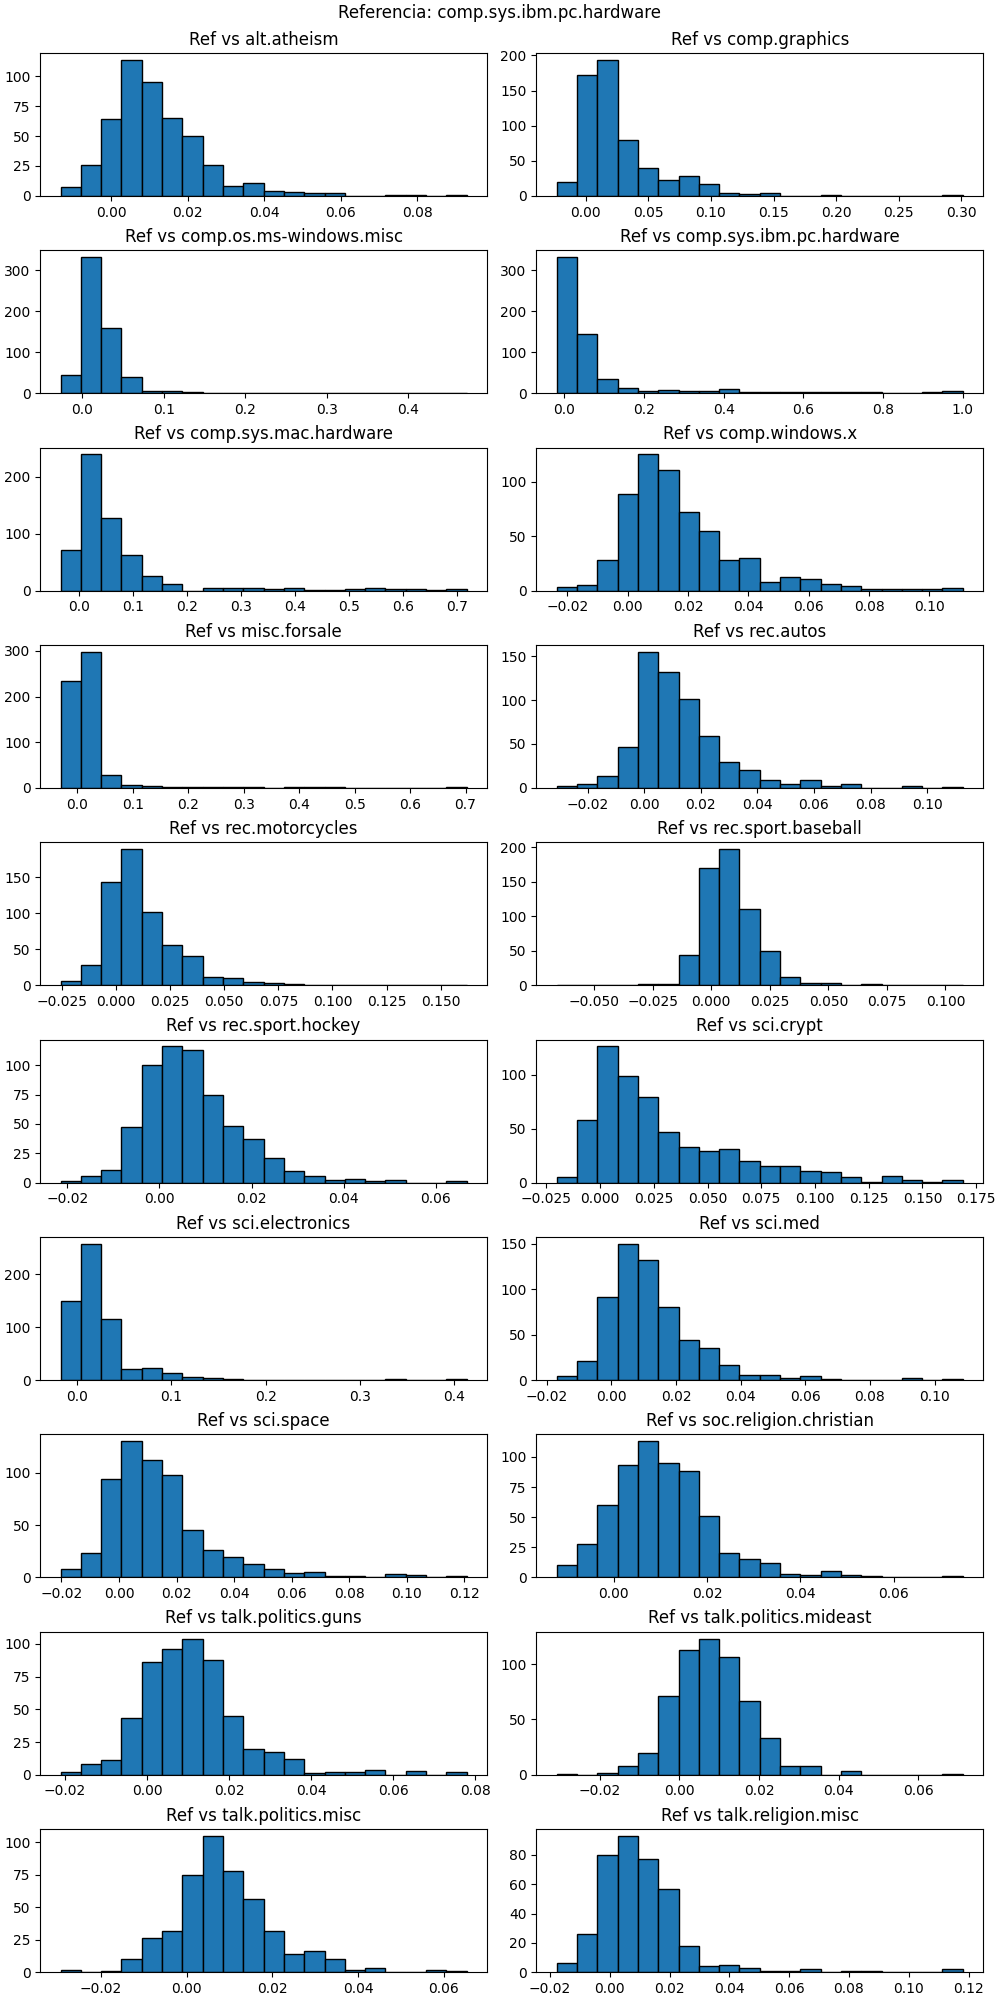

In [15]:
# Hago un diccionario para agrupar los articulos por categoria
articles_by_category = {}
indexes_by_category = {}

for i, category in enumerate(TNG_train.target_names):
    category_articles = np.array([[TNG_train.data[j], j] for j in range(len(TNG_train.data)) if TNG_train.target[j] == i])
    articles_by_category[category] = category_articles

reference_article = random.choice(TNG_train.target)

plt.clf()
fig = plt.figure(figsize=(10, 20), constrained_layout=True, )

fig.suptitle(f"Referencia: {TNG_train.target_names[TNG_train.target[reference_article]]}")
for i, category in enumerate(TNG_train.target_names):
    plt.subplot(10, 2, i+1)
    plt.title(f'Ref vs {category}')
    hist_data = [matriz_similaridad[reference_article, int(j)] for j in articles_by_category[category][..., 1] if j != reference_article]
    plt.hist(hist_data, edgecolor='black', bins=20)

plt.show()

Truncated SVD no cambio demasiado los resultados. Es mas, parece que tienen un poco mas de varianza los resultados. Tiene sentido por la reduccion de dimensionalidad. De todas formas ambos resultados tienen sentido. Se puede ver que para las distintoas categorias base se observa un similaridad mayor que con otras. Es interesante que por ejemplo la categoria de Computacion se diferencia muy bien de la de Religion.

# Termino-Documento y termino clase

Mirar los 3 terminos mas populares por categoria.

In [112]:
cv = CountVectorizer(ngram_range=(1,2), max_df=1.0, min_df=10, max_features=None, stop_words='english')
res = cv.fit_transform(TNG_train.data)
display(res)

<11314x12721 sparse matrix of type '<class 'numpy.int64'>'
	with 634074 stored elements in Compressed Sparse Row format>

In [3]:
cv = TfidfVectorizer(ngram_range=(1,2), max_df=1.0, min_df=10, max_features=None, stop_words='english')
res = cv.fit_transform(TNG_train.data)
display(res)

<11314x12721 sparse matrix of type '<class 'numpy.float64'>'
	with 634074 stored elements in Compressed Sparse Row format>

In [4]:
termDoc = res.T

In [5]:
termCount = np.array(termDoc.sum(axis=1))[:, 0]

In [6]:
indexes = np.argsort(termCount)
sortedFeatures = cv.get_feature_names_out()[indexes]

In [7]:
sortedFeatures

array(['nrhj gk', 'giz ghj', 'bhj gk', ..., 'know', 'just', 'like'],
      dtype=object)

In [8]:
matriz_similaridad = cosine_similarity(termDoc)

In [9]:
terms2index = {index: term for term, index in enumerate(cv.get_feature_names_out())}

In [81]:
term1 = "transistor"
term2 = "diode"

print(f"La similaridad entre {term1} y {term2} es: {matriz_similaridad[terms2index[term1], terms2index[term2]]}")

La similaridad entre transistor y diode es: 0.2739573068443901


Implemente este comparador de terminos para jugar. Muy divertido. Funciona mucho mejor con TFIDF.
probe:

Transistor y Diode: 0.274 muy bueno

bush y president: 0.13 genial

god y true: 0.1 jajaja

gay y homosexual: 0.25 clara correlacion en significado.

In [68]:
termClass = np.array([res[TNG_train.target == t, :].sum(axis=0) for t in range(20)])[:, 0, :]

In [69]:
termClass.shape

(20, 101322)

In [70]:
matriz_similaridad = cosine_similarity(termClass)
print(matriz_similaridad.shape)

(20, 20)


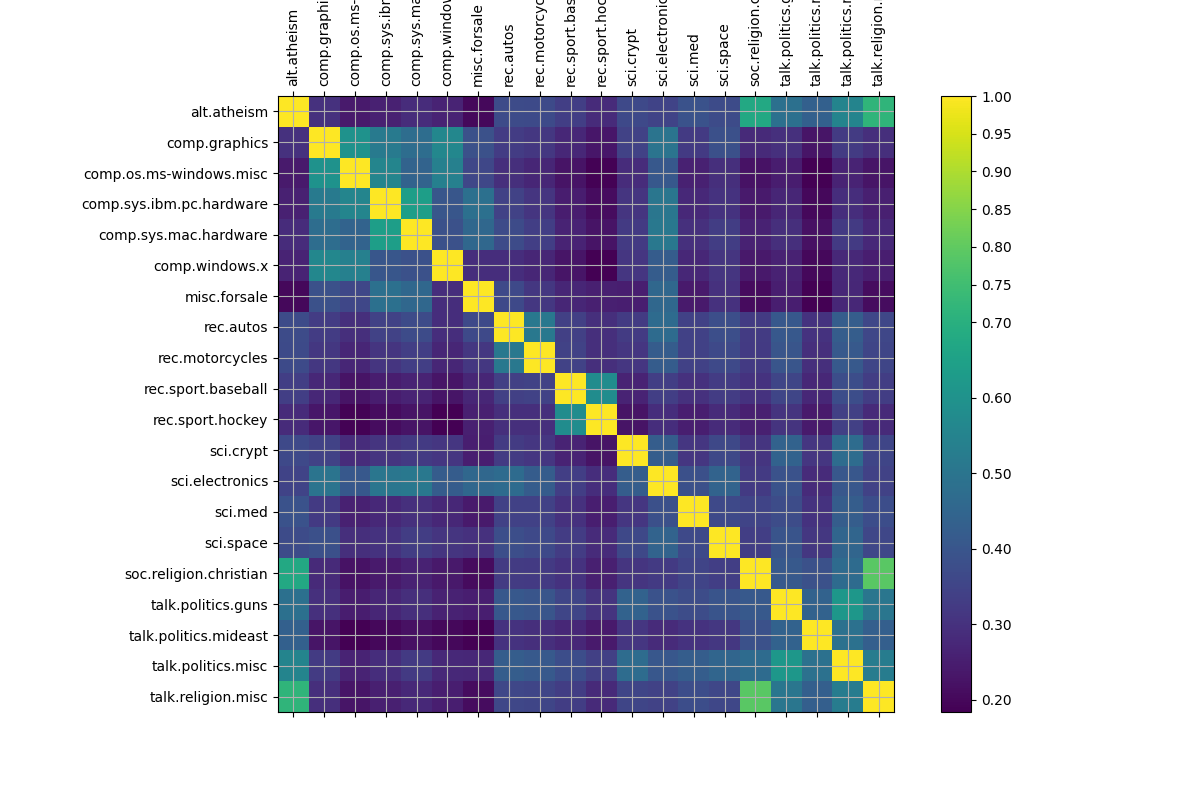

In [71]:
plt.cla()

fig, ax = plt.subplots(figsize=(12,8))
cax = ax.matshow(matriz_similaridad, interpolation='nearest')
ax.grid(True)
plt.title('Class Similarity matrix')
plt.xticks(range(20), TNG_train.target_names, rotation=90)
plt.yticks(range(20), TNG_train.target_names)
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

Muy bueno como la de windows se distingue fuertemente de otras. 
Tambien probe la diferencia entre count vectorizer y TFIDF. es com la noche y el dia. CV da similitudes del oreden de 0.5 entre clases. pero TFIDF hace que se distingan mucho mas. muy piola

# Termino a Termino 

In [3]:
tokenizer = Tokenizer(num_words=10000)

In [4]:
tokenizer.fit_on_texts(TNG_train.data)

In [5]:
seqs=tokenizer.texts_to_sequences(TNG_train.data)

In [6]:
seqs[0][0: 10]

[7, 26, 1383, 24, 160, 64, 43, 105, 61, 15]

In [7]:
V = 10000 + 1

In [8]:
counts_matrix=lil_matrix((V-1, V-1))

In [9]:
seqs=np.hstack(seqs)
seqs.shape

(2153559,)

In [11]:
seqs=seqs.astype(int)

In [12]:
pairs, labels = skipgrams(sequence=list(seqs), vocabulary_size=V, window_size=5, negative_samples=0, sampling_table=make_sampling_table(V, sampling_factor=1), shuffle=False)


In [13]:
pairs_u, counts = np.unique(pairs,return_counts=True, axis=0)

In [14]:
counts

array([55430, 29896, 43050, ...,     1,     1,     1])

In [15]:
tokenizer.sequences_to_texts(pairs_u)

['the the',
 'the to',
 'the of',
 'the a',
 'the and',
 'the i',
 'the in',
 'the is',
 'the that',
 'the it',
 'the for',
 'the you',
 'the this',
 'the on',
 'the be',
 'the are',
 'the have',
 'the with',
 'the not',
 'the as',
 'the 1',
 'the or',
 'the if',
 'the but',
 'the was',
 'the they',
 'the 0',
 'the 2',
 'the from',
 'the by',
 'the 3',
 'the at',
 "the '",
 'the x',
 'the m',
 'the an',
 'the can',
 'the will',
 'the all',
 'the my',
 'the one',
 'the there',
 'the what',
 'the would',
 'the do',
 'the he',
 'the we',
 'the about',
 'the q',
 'the has',
 'the so',
 'the your',
 'the no',
 'the some',
 'the any',
 'the 4',
 'the max',
 'the which',
 'the 5',
 'the me',
 'the w',
 'the who',
 'the out',
 'the 7',
 'the more',
 'the p',
 'the were',
 'the people',
 'the their',
 'the when',
 'the like',
 'the other',
 'the r',
 "the don't",
 'the g',
 'the up',
 'the just',
 'the s',
 'the 8',
 'the get',
 'the only',
 'the 6',
 'the them',
 'the had',
 'the know',
 'the 

In [16]:
pairs_u

array([[   1,    1],
       [   1,    3],
       [   1,    4],
       ...,
       [9999, 8639],
       [9999, 8904],
       [9999, 9341]])

In [14]:
for num,(pair,count) in enumerate(zip(pairs_u, counts)):
    if num%1000 ==0:
        print(f'\r{num}', end="")
    counts_matrix[pair[0],pair[1]] += count

4127000

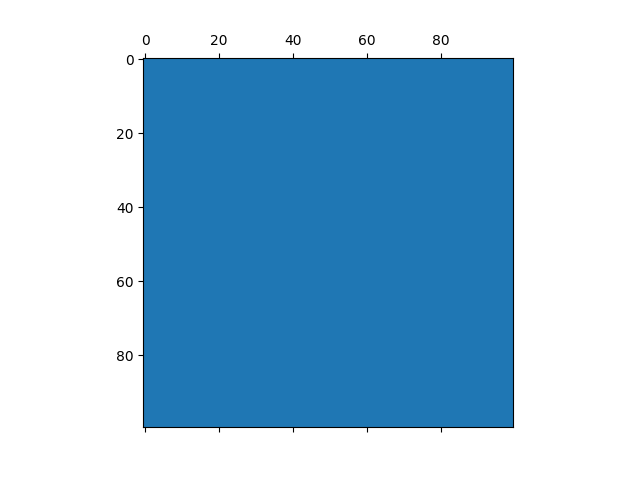

In [18]:
plt.cla()
plt.spy(counts_matrix[:100, :100])
plt.show()

No muy esparsa

In [19]:
from sklearn.neighbors import NearestNeighbors

In [40]:
red = TruncatedSVD(n_components=300)
TNG_cv_red = red.fit_transform(counts_matrix)

In [48]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")
neigh.fit(TNG_cv_red)


NearestNeighbors(metric='cosine', n_neighbors=20)

In [49]:
idx_1 = tokenizer.word_index["president"]
dist, neig = neigh.kneighbors(TNG_cv_red[idx_1:idx_1+1])
for n, s in zip(neig[0], dist[0]):
    print(tokenizer.index_word[n], " Distance: ", s)

president  Distance:  9.992007221626409e-16
administration  Distance:  0.03398334684175608
government  Distance:  0.04007416292328403
nsa  Distance:  0.04013062355661878
media  Distance:  0.041739804035243466
entire  Distance:  0.04185792558845258
despite  Distance:  0.04203917463618323
bible  Distance:  0.04250093532832322
minister  Distance:  0.04257206052741436
community  Distance:  0.04259797581701219
actual  Distance:  0.044356349296298614
church  Distance:  0.04453569434397686
original  Distance:  0.045566829226204475
of  Distance:  0.04573873258466865
whole  Distance:  0.04597249550049698
regime  Distance:  0.04658598488355903
leadership  Distance:  0.046688343235788965
above  Distance:  0.046708913700232335
fbi  Distance:  0.04732056580447652
first  Distance:  0.04777248740179196


# PPMI


In [15]:
marginalprob = counts_matrix[1:, 1:].sum(axis=1)/counts_matrix[1:, 1:].sum()

In [16]:
probs_mat = counts_matrix[1:, 1:]/counts_matrix[1:, 1:].sum()

In [17]:
PMI = probs_mat/(marginalprob * marginalprob.T)

In [18]:
PMI

matrix([[ 1.06142065,  0.        ,  1.1436578 , ...,  0.        ,
          0.        ,  0.12687394],
        [ 0.        , 28.2109797 ,  0.        , ...,  1.95644545,
          1.5216798 ,  1.30429697],
        [ 1.14702262,  0.        ,  0.87348955, ...,  0.        ,
          0.50697   ,  0.        ],
        ...,
        [ 0.        ,  1.95644545,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  1.5216798 ,  0.50697   , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.12687394,  1.30429697,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [35]:
PMI=np.array(PMI)
PMI.shape

(9999, 9999)

In [20]:
PMI=PMI*(PMI>1)+1e-8
PMI = np.log(PMI)
PMI=PMI*(PMI>0)+1e-8

In [39]:
red = TruncatedSVD(n_components=300)
TNG_cv_redPMI = red.fit_transform(PMI)

In [22]:
from sklearn.neighbors import NearestNeighbors

In [37]:
neighPMI = NearestNeighbors(n_neighbors=20, metric="cosine")
neighPMI.fit(TNG_cv_red)


NearestNeighbors(metric='cosine', n_neighbors=20)

In [47]:
idx_1 = tokenizer.word_index["president"]
distPMI, neigPMI = neighPMI.kneighbors(TNG_cv_redPMI[idx_1-1:idx_1])

for n, s in zip(neigPMI[0], distPMI[0]):
    print(tokenizer.index_word[n+1], ", Distance: ", s)

[0.17025185 0.30828319 0.32850713 0.34548052 0.35966294 0.3767733
 0.38742849 0.38974848 0.40513488 0.41233619 0.41466198 0.41675722
 0.41681983 0.42521417 0.42844702 0.43349127 0.43721478 0.43897658
 0.4430685  0.44487173]
president , Distance:  0.17025184533379845
stephanopoulos , Distance:  0.3082831877545298
senator , Distance:  0.32850713224731676
secretary , Distance:  0.34548051995746953
mr , Distance:  0.3596629392645998
congress , Distance:  0.3767732967110504
meeting , Distance:  0.3874284920795691
stimulus , Distance:  0.389748476256665
president's , Distance:  0.40513488304927225
clinton , Distance:  0.41233619066220106
dole , Distance:  0.4146619843132402
senior , Distance:  0.4167572212166393
administration , Distance:  0.41681983104433706
myers , Distance:  0.4252141675859735
yeltsin , Distance:  0.4284470234338129
we're , Distance:  0.4334912719750117
vat , Distance:  0.4372147761868125
briefing , Distance:  0.43897658319848476
talked , Distance:  0.4430684992064333
tod

# PPMI vs RAW term-term matrix

Hice algunas pruebas jugando con lo de kneighbours y la verdad la PPMI funciono bien para mejorar la captura de la relacion semantica en el espacio de embedding, pero en algunos casos anduvo mejor lo otro. El ejemplo de god lo muestra funcionando bien, sin PPMI se ven palabras como us, all, the, pero en el otro caso estas ya no estan. 


## vecinos de la palabra "god"

aacon matriz terminotermino

god  Distance:  0.0
jesus  Distance:  0.022716801192266045
death  Distance:  0.027189427632591245
life  Distance:  0.029549612398702685
truth  Distance:  0.030598006219020646
faith  Distance:  0.03237587583338852
one  Distance:  0.03273904390802673
hell  Distance:  0.03282071424903499
god's  Distance:  0.033785726035818864
evil  Distance:  0.03450486872659386
the  Distance:  0.035260469519845405
scripture  Distance:  0.03574633403718919
israel  Distance:  0.03591013631201334
christ  Distance:  0.0362705118722052
eternal  Distance:  0.03653942951655953
indeed  Distance:  0.039620435119543496
all  Distance:  0.04003852966261734
us  Distance:  0.04072684776129376
christianity  Distance:  0.04123268965829363
being  Distance:  0.04128575367434839

con PMMI

god , Distance:  0.0
god's , Distance:  0.15070874266119616
jesus , Distance:  0.1649187893480777
christ , Distance:  0.17889948899552643
faith , Distance:  0.2138562764316192
spirit , Distance:  0.24409535042595987
lord , Distance:  0.2595474391799426
eternal , Distance:  0.270175469607124
believe , Distance:  0.27284451518564845
sins , Distance:  0.2759373942502692
heaven , Distance:  0.2823368325308371
salvation , Distance:  0.2832207261954509
truth , Distance:  0.2987626298182502
not , Distance:  0.2989387289477956
that , Distance:  0.3038660586463853
love , Distance:  0.30838737442213515
grace , Distance:  0.3157078399358886
bible , Distance:  0.3159047114661395
sin , Distance:  0.3218869242580097
satan , Distance:  0.32197309232395743

## vecinos palabra president

term-term

president  Distance:  9.992007221626409e-16
administration  Distance:  0.03398334684175608
government  Distance:  0.04007416292328403
nsa  Distance:  0.04013062355661878
media  Distance:  0.041739804035243466
entire  Distance:  0.04185792558845258
despite  Distance:  0.04203917463618323
bible  Distance:  0.04250093532832322
minister  Distance:  0.04257206052741436
community  Distance:  0.04259797581701219
actual  Distance:  0.044356349296298614
church  Distance:  0.04453569434397686
original  Distance:  0.045566829226204475
of  Distance:  0.04573873258466865
whole  Distance:  0.04597249550049698
regime  Distance:  0.04658598488355903
leadership  Distance:  0.046688343235788965
above  Distance:  0.046708913700232335
fbi  Distance:  0.04732056580447652
first  Distance:  0.04777248740179196

PPMI

president , Distance:  0.17025184533379845
stephanopoulos , Distance:  0.3082831877545298
senator , Distance:  0.32850713224731676
secretary , Distance:  0.34548051995746953
mr , Distance:  0.3596629392645998
congress , Distance:  0.3767732967110504
meeting , Distance:  0.3874284920795691
stimulus , Distance:  0.389748476256665
president's , Distance:  0.40513488304927225
clinton , Distance:  0.41233619066220106
dole , Distance:  0.4146619843132402
senior , Distance:  0.4167572212166393
administration , Distance:  0.41681983104433706
myers , Distance:  0.4252141675859735
yeltsin , Distance:  0.4284470234338129
we're , Distance:  0.4334912719750117
vat , Distance:  0.4372147761868125
briefing , Distance:  0.43897658319848476
talked , Distance:  0.4430684992064333
today , Distance:  0.44487172562809174

# Conclusiones


En un principio este trabajo ya me dejo entendiendo embedding mucho mejor. Tambien veo la utilidad de las distintas variantes de la informacion que se puede sacar de un corpus completo dependiendo de la aplicacion. El hecho de utilizar una ventana contextual y como cambia lo que puede capturar el embedding. Lindo tema la verdad